# Introducción

El presente notebook realiza una comparación de performance (speed up) entre 3 diferentes implementaciones proporcionadas por PySparl: Dataframes, rdds y SQL. Para lo anterior, realizaremos la lectura de dataset abiertos de los registros de taxis durante cierto periodo de la ciudad de New York.

Con los datos obtenidos, se realizarán diferentes analisis para enteder los datos, sus tipos, obtener información relevante como la duración promedia de taxis por hora, las rutas mas frecuentes entre otros aspectos que se muestran mas adelante. 

Finalmente, se presenta una sección donde se muestran los resultados del analisis de performace realizado con un estudio particular a cual se le aplico los 3 metodos anteriormente mencionados.

Data dictionary of this dataset can be found in the following link:
https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf

Para iniciar, importaremos las librerias necesarias para utilizar leeer, analisis y visualizar los datos, principalmente basados enlas librerias de pyspark

In [2]:
# Packages for data visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, ScalarFormatter

In [3]:
#Reset kernel when start this notebook
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark import SparkContext, SparkConf
import time

In [4]:
def create_spark_session(number_threads):
    #local[*] -> Number of threads
    spark = SparkSession.builder.master(f'local[{number_threads}]').getOrCreate()
    
    sc = spark.sparkContext
    print("spark session obtained!")
    return spark

def stop_spark_session(session):
    session.stop()
    print("Spark session stopped")

In [5]:
#spark_session = create_spark_session("*")
#print(spark_session.sparkContext.defaultParallelism)
#print(spark_session.version)

In [6]:
#stop_spark_session(spark_session)

In [7]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Your runtime has 6.6 gigabytes of available RAM



In [27]:
#spark = SparkSession.builder.master("local[5]").appName("SparkByExamples.com").getOrCreate()

#df = spark.range(0,20)
#df2 = df.repartition(6)
#print(df2.rdd.getNumPartitions())

#df.write.mode(SaveMode.Overwrite)csv("partition.csv")

6


# Lectura de datos

* Debido a que las operaciones en spark son "lazy", necesitamos usar la función show() para ejecutar el computo y ver los resultados

In [8]:
def read_parquet_file(spark_session, path, type, partitions = None):
    sdf = spark_session.read.format(type).option("inferSchema", "true").option("timestampFormat","yyyy-MM-dd HH:mm:ss").option("header", "true").option("mode", "DROPMALFORMED").load(path)
    if partitions is not None:
        console.log("repartition executed")
        sdf = sdf.repartition(partitions)
    return sdf

In [37]:
spark_session = create_spark_session('*')
path = "dataset/yellow_tripdata_2017-01.parquet"
sdf = read_parquet_file(spark_session, path, "parquet")
print(f'File read. Number of partitions {sdf.rdd.getNumPartitions()}')

spark session obtained!
File read. Number of partitions 4


In [10]:
#Revisamos el tipo de dao de cada columna
sdf.printSchema()

root
 |-- VendorID: long (nullable = true)
 |-- tpep_pickup_datetime: timestamp_ntz (nullable = true)
 |-- tpep_dropoff_datetime: timestamp_ntz (nullable = true)
 |-- passenger_count: long (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- RatecodeID: long (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: long (nullable = true)
 |-- DOLocationID: long (nullable = true)
 |-- payment_type: long (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)
 |-- congestion_surcharge: integer (nullable = true)
 |-- airport_fee: integer (nullable = true)



In [11]:
#See the number of records
sdf.count()

9710820

## Valores Null

Antes de realizar los estudios, verificamos la clidad de los datos mediante la identificación de valores nulos.

In [12]:
from pyspark.sql.functions import col, sum, when, expr

In [13]:
# Crea una lista de expresiones que cuentan los valores nulos de cada columna
null_counts = [sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in sdf.columns]

# Aplicar las expresiones al Dataframe y mostrar los resultados
# El '*' es usado para desempacar la lista y pasar cada expresion coomo un argumento por separado
# la funcion agg es para aplicar expresiones al ataframe
sdf.agg(*null_counts).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       0|                   0|                    0|              0|            0|         0|                 0|           0|           0|           0|          0|    0|      0|         

In [38]:
#Las columnas 'congestion_surcharge' y 'airport_fee' contienen valores null, entonces las eliminamos
sdf = sdf.drop(*["congestion_surcharge","airport_fee"])

Null Values by RDD

Null Values by DataFrame

Null Values by SQL

## Tomar una muestra del dataset (opcional)
Seleccionar una serie de registros de manera dinamica con el objetivo de ejecutar las operaciones de una mejor manera

In [11]:
#sdf = sdf.sample(withReplacement=False, fraction=0.5, seed=15)
#new_size = sdf.count()
#print(f"Tamaño de la muestra '{new_size}'")

Size of the sample '4856845'


# Estudio #1 -  Las rutas mas frecuentes

Para analizar los resultados de las rutas, incluimos la información de las zonas para facilitar la lectura y la interpretación e los datos.

In [15]:
path = "dataset/taxi_zone_lookup.csv"
sdf_zones = read_parquet_file(spark_session, path, "csv")
sdf_zones.show()

+----------+-------------+--------------------+------------+
|LocationID|      Borough|                Zone|service_zone|
+----------+-------------+--------------------+------------+
|         1|          EWR|      Newark Airport|         EWR|
|         2|       Queens|         Jamaica Bay|   Boro Zone|
|         3|        Bronx|Allerton/Pelham G...|   Boro Zone|
|         4|    Manhattan|       Alphabet City| Yellow Zone|
|         5|Staten Island|       Arden Heights|   Boro Zone|
|         6|Staten Island|Arrochar/Fort Wad...|   Boro Zone|
|         7|       Queens|             Astoria|   Boro Zone|
|         8|       Queens|        Astoria Park|   Boro Zone|
|         9|       Queens|          Auburndale|   Boro Zone|
|        10|       Queens|        Baisley Park|   Boro Zone|
|        11|     Brooklyn|          Bath Beach|   Boro Zone|
|        12|    Manhattan|        Battery Park| Yellow Zone|
|        13|    Manhattan|   Battery Park City| Yellow Zone|
|        14|     Brookly

In [16]:
df_filtered = sdf[["PULocationID","DOLocationID","trip_distance","tolls_amount","total_amount"]]
# Cruzamos datos
df_crossdata = df_filtered.join(sdf_zones, col("LocationID") == col("PULocationID"))
# Visualizamos el cruce de los datos. 
df_crossdata.show()

+------------+------------+-------------+------------+------------+----------+---------+--------------------+------------+
|PULocationID|DOLocationID|trip_distance|tolls_amount|total_amount|LocationID|  Borough|                Zone|service_zone|
+------------+------------+-------------+------------+------------+----------+---------+--------------------+------------+
|         140|         236|          1.2|         0.0|         7.8|       140|Manhattan|     Lenox Hill East| Yellow Zone|
|         237|         140|          0.7|         0.0|         6.3|       237|Manhattan|Upper East Side S...| Yellow Zone|
|         140|         237|          0.8|         0.0|         6.8|       140|Manhattan|     Lenox Hill East| Yellow Zone|
|          41|          42|          1.1|         0.0|         7.3|        41|Manhattan|      Central Harlem|   Boro Zone|
|          48|         263|          3.0|         0.0|        12.3|        48|Manhattan|        Clinton East| Yellow Zone|
|         236|  

In [17]:
#Renombramos los datos para no confundirlos con el cruce con los datos de dropoff
df_crossdata = df_crossdata.withColumnRenamed("Borough","borough_pickup")
df_crossdata = df_crossdata.withColumnRenamed("Zone","zone_pickup")
df_crossdata = df_crossdata.withColumnRenamed("service_zone","service_pickup")

In [20]:
# Eliminamos la columna que se añadio para hacer nuevamente el cruce para los datos del dropoff
#Esta celda la ejecutamos dos veces, la primera cuando se cruzan los datos para pickup y la segunda cuando se cruzan datos para el dropoff
df_crossdata = df_crossdata.drop("LocationID")

In [19]:
df_crossdata = df_crossdata.join(sdf_zones, col("LocationID") == col("DOLocationID"))
df_crossdata = df_crossdata.withColumnRenamed("Borough","borough_dropoff")
df_crossdata = df_crossdata.withColumnRenamed("Zone","zone_dropoff")
df_crossdata = df_crossdata.withColumnRenamed("service_zone","service_dropoff")

In [21]:
#Visualizamos el dataset luego de las anteriores operaciones
df_crossdata.show()

+------------+------------+-------------+------------+------------+--------------+--------------------+--------------+---------------+--------------------+---------------+
|PULocationID|DOLocationID|trip_distance|tolls_amount|total_amount|borough_pickup|         zone_pickup|service_pickup|borough_dropoff|        zone_dropoff|service_dropoff|
+------------+------------+-------------+------------+------------+--------------+--------------------+--------------+---------------+--------------------+---------------+
|         140|         236|          1.2|         0.0|         7.8|     Manhattan|     Lenox Hill East|   Yellow Zone|      Manhattan|Upper East Side N...|    Yellow Zone|
|         237|         140|          0.7|         0.0|         6.3|     Manhattan|Upper East Side S...|   Yellow Zone|      Manhattan|     Lenox Hill East|    Yellow Zone|
|         140|         237|          0.8|         0.0|         6.8|     Manhattan|     Lenox Hill East|   Yellow Zone|      Manhattan|Upper 

In [22]:
#Con la información anterior, agrupamos por ruta pickup y dropoff
grouped_sdf = df_crossdata.groupBy("borough_pickup", "borough_dropoff").agg(F.count("total_amount").alias("total_trips")).orderBy(col("total_trips").desc())
grouped_sdf.show()

+--------------+---------------+-----------+
|borough_pickup|borough_dropoff|total_trips|
+--------------+---------------+-----------+
|     Manhattan|      Manhattan|    8209134|
|        Queens|      Manhattan|     297952|
|     Manhattan|         Queens|     291300|
|     Manhattan|       Brooklyn|     281317|
|        Queens|         Queens|     148161|
|       Unknown|        Unknown|     145607|
|      Brooklyn|       Brooklyn|      89365|
|        Queens|       Brooklyn|      75518|
|     Manhattan|          Bronx|      42230|
|      Brooklyn|      Manhattan|      35845|
|       Unknown|      Manhattan|      20018|
|     Manhattan|        Unknown|      17656|
|     Manhattan|            EWR|      14390|
|        Queens|        Unknown|       9636|
|        Queens|          Bronx|       8766|
|      Brooklyn|         Queens|       7317|
|         Bronx|          Bronx|       5154|
|       Unknown|         Queens|       2685|
|         Bronx|      Manhattan|       2222|
|     Manh

La tabla anterior muestra el top 20 de las rutas más frecuentes registradas en enero de 2017. Los viajes en manhattan ocupan la primera posición y, a partir de dicha posición, aparecen múltiples veces ya sea como zona de recogida o entrega, lo cual evidencia que es una zona con alta afluencia de pasajeros que requieren viajar en taxi.

Adicionalmente, se evidencia ciertas zonas bajo el nombre de Unkown que no permiten conocer a que zona hacen referencia.

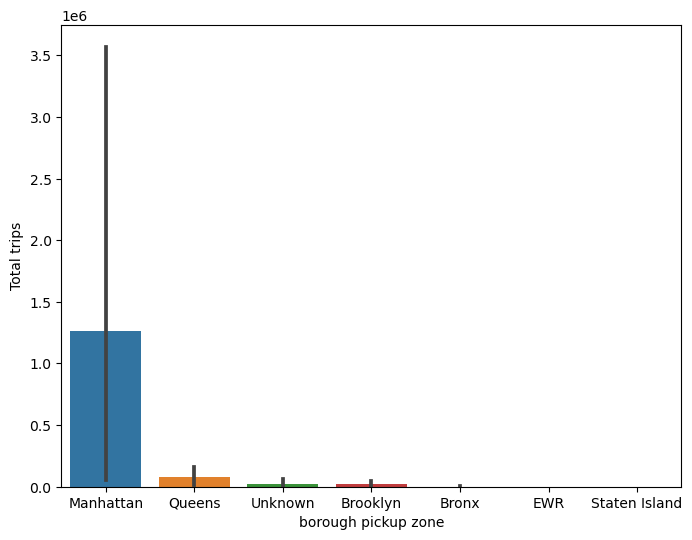

In [23]:
plt.figure(figsize=(8, 6))
result_df_p = grouped_sdf.toPandas()
barplot = sns.barplot(data=result_df_p, x="borough_pickup", y="total_trips")
plt.xlabel("borough pickup zone")
plt.ylabel("Total trips")

# Show the plot
plt.show()

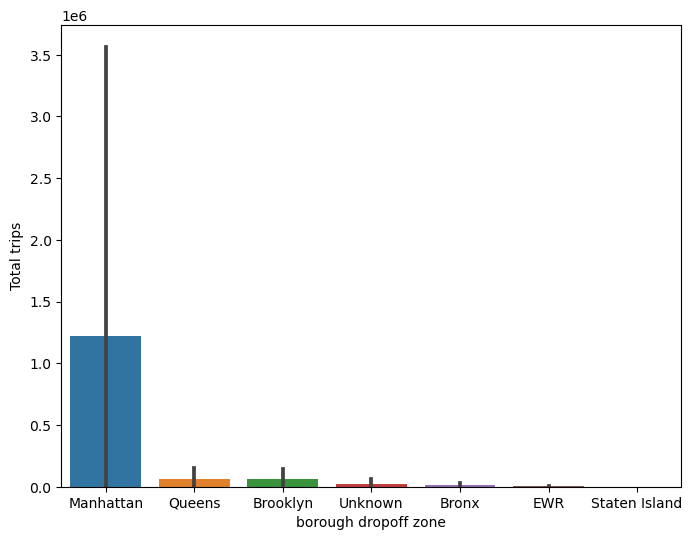

In [24]:
plt.figure(figsize=(8, 6))
result_df_p = grouped_sdf.toPandas()
barplot = sns.barplot(data=result_df_p, x="borough_dropoff", y="total_trips")
plt.xlabel("borough dropoff zone")
plt.ylabel("Total trips")

# Show the plot
plt.show()

# Estudio #2 - Las rutas que mas dinero generaron

Basado en el analisis realizado en la sección anterior, se procedio a calcular las rutas que mas ingresos generaron.

In [25]:
grouped_sdf = df_crossdata.groupBy("borough_pickup", "borough_dropoff").agg(F.sum("total_amount").alias("total_amount"))
#Dividimos entre 100.000 para una mejor visualización
grouped_sdf = grouped_sdf.withColumn("total_amount", col("total_amount") / 100000)
grouped_sdf = grouped_sdf.orderBy(col("total_amount").desc())
grouped_sdf.show()

+--------------+---------------+------------------+
|borough_pickup|borough_dropoff|      total_amount|
+--------------+---------------+------------------+
|     Manhattan|      Manhattan| 984.6744593217379|
|        Queens|      Manhattan|  155.418054599954|
|     Manhattan|         Queens| 116.7562286000072|
|     Manhattan|       Brooklyn| 75.43783349982648|
|        Queens|       Brooklyn|34.656703899978965|
|        Queens|         Queens|31.414253899956726|
|       Unknown|        Unknown|25.504346399995875|
|     Manhattan|        Unknown|13.655903500002227|
|     Manhattan|            EWR|13.426647200001526|
|     Manhattan|          Bronx|13.037575200007414|
|      Brooklyn|       Brooklyn|10.998957400010314|
|      Brooklyn|      Manhattan| 8.172497200001867|
|        Queens|        Unknown| 8.067211300000444|
|        Queens|          Bronx| 4.798081900000567|
|       Unknown|      Manhattan|3.3517394999993173|
|      Brooklyn|         Queens|2.1265201999998786|
|     Manhat

As we can see, the the routes that started and finished in manhattan were the ones that earned the most money. Next, queens to manhattan and, in the third place, manhattan to queens.

# Estudio #3 - Propinas generadas por hora

In [28]:
# Comenzar a medir el tiempo
start_time = time.time()

df_limited = sdf["tip_amount","DOLocationID"]

# Agrupar por 'DOLocationID' y calcular la media de 'tip_amount'
df_avg_tips = df_limited.groupBy("DOLocationID").agg({"tip_amount": "avg"})

# Renombrar columnas para mayor claridad
df_avg_tips = df_avg_tips.withColumnRenamed("avg(tip_amount)", "average_tip")

# Si quieres ordenar por la media de propina de mayor a menor:
df_avg_tips_ordered = df_avg_tips.orderBy("average_tip", ascending=False)

df_avg_tips_ordered.show()

# Finalizar medición del tiempo
end_time = time.time()
execution_time = end_time - start_time
print(f"Tiempo de ejecución: {execution_time:.2f} segundos.")

+------------+------------------+
|DOLocationID|       average_tip|
+------------+------------------+
|         204|15.657611940298507|
|          44|12.607241379310345|
|           2|12.126249999999999|
|           1|10.954543615676386|
|         109| 10.73825581395349|
|         176|10.382933333333337|
|          84| 9.383253012048192|
|           5| 9.147704918032787|
|         265| 8.874212609556167|
|         214| 8.320777777777776|
|         245| 8.035326086956523|
|          23| 7.677205240174674|
|         172| 7.591983471074382|
|         251| 7.571948051948051|
|         118| 7.352035928143712|
|         206|7.0175956284152985|
|         132| 6.725178089023828|
|           6| 6.120670103092784|
|         156| 5.911585365853658|
|         138|  5.85998675301736|
+------------+------------------+
only showing top 20 rows

Tiempo de ejecución: 1.54 segundos.


# Estudio #4 - Taxi Velocity average in each hour

El siguiente estudio presenta la implementación en los 3 metodos mencionados inicialmente. Se iniciara por el procesamiento de Dataframes. A continuación con RDD y, por ultimo, con SQL

In [43]:
#Realizamos las importaciones necesarias para las operaciones del presente estudio
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql.functions import hour, avg, max, min

## Metodo 1 - Dataframe

In [39]:
#Calculamos la diferencia de tiempo entre pickup y dropoff
sdf = sdf.withColumn("duration", col("tpep_dropoff_datetime")-col("tpep_pickup_datetime"))
#sdf.select("duration").show()

### Verificar la duración de los viajes

In [40]:
#convertir a segundos manualmente a través de funciones definidas por el usuario (UDF)
def interval_to_seconds(interval):
    total_seconds = interval.total_seconds()
    return int(total_seconds)

interval_to_seconds_udf = udf(interval_to_seconds, IntegerType())

In [41]:
# Utilizamos la UDF para extraer segundos y almacenarlos en una nueva columna
sdf = sdf.withColumn("duration", interval_to_seconds_udf(col("duration")))
#sdf.select("duration").show()

In [42]:
#Verificamos valores
sdf.filter(col("duration") < 0).show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|duration|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------+
|       1| 2017-01-10 15:15:25|  2017-01-06 00:23:28|              1|          3.0|         1|                 N|         246|         239|           1|       13.0|  0.0|    0.5|      2.75|         0.0|                  0.3|       16.55| -399117|
|       1| 2

In [ ]:
sdf.filter(col("duration") == 0).show()

Todos los registros anteriores muestran que los viajes terminaron al mismo tiempo que comenzaron.

Debido a todos estos registros, procedemos a eliminarlos.

In [ ]:
sdf = sdf.filter(col("duration") > 0)
size_after_reduction = sdf.count()
print(f"Size of the sample '{size_after_reduction}'")

### Calcular la velocidad de cada viaje

In [ ]:
#Como la columna de duración está en segundos, tenemos que dividir el valor entre 3600 para pasarlas a horas
sdf = sdf.withColumn("velocity",col("trip_distance")/(col("duration")/3600))
sdf.select("velocity").show()

*Las unidades de velocidad estan en millas por hora

### Calculamos el promedio de la velocidad por hora

In [ ]:
sdf = sdf.withColumn("hour_pickup", hour(col("tpep_pickup_datetime")))
sdf = sdf.withColumn("hour_dropoff", hour(col("tpep_dropoff_datetime")))
sdf.show()

In [ ]:
result_df = sdf.groupBy("hour_pickup").agg(avg("velocity").alias("VelocityAvg")).orderBy("hour_pickup")

result_df.show(24)

### Visualización de resultados

In [ ]:
plt.figure(figsize=(10, 6))
result_df_p = result_df.toPandas()
barplot = sns.barplot(data=result_df_p, x="hour_pickup", y="VelocityAvg")
plt.xlabel("Hour")
plt.ylabel("Average velocity")

# Show the plot
plt.show()

### Resumen

Las siguientes dos celdas fueron las utilizadas para la medición del tiempo. Contienen todas las operaciones del estudio 4 de una manera mas concreta

In [78]:
#Operations reduced
from pyspark.sql.functions import hour, udf, avg, col
from pyspark.sql.types import IntegerType, StringType

#convert to seconds manually through User defined functions (UDF)
def interval_to_seconds(interval):
    total_seconds = interval.total_seconds()
    return int(total_seconds)

interval_to_seconds_udf = udf(interval_to_seconds, IntegerType())

# START THE TIMER
DFstarttime = time.time()
sdfDF = sdf.withColumn("duration", col("tpep_dropoff_datetime")-col("tpep_pickup_datetime"))
sdfDF = sdfDF.withColumn("duration", (interval_to_seconds_udf(col("duration")) / 3600))
sdfDF = sdfDF.filter(col("duration") > 0)
sdfDF = sdfDF.withColumn("velocity",col("trip_distance")/col("duration"))
sdfDF = sdfDF.withColumn("hour_pickup", hour(col("tpep_pickup_datetime")))
sdfDF = sdfDF.withColumn("hour_dropoff", hour(col("tpep_dropoff_datetime")))

result_df = sdfDF.groupBy("hour_pickup").agg(avg("velocity").alias("VelocityAvg")).orderBy("hour_pickup")
result_df.show(24)
#STOP TIMER
DFendtime = time.time()

+-----------+------------------+
|hour_pickup|       VelocityAvg|
+-----------+------------------+
|          0|17.135377162085373|
|          1|  17.7084494704235|
|          2|18.005655850937046|
|          3|18.156252751944653|
|          4| 20.76540968125122|
|          5| 22.53105310024046|
|          6|18.062101710891028|
|          7|13.693853937236215|
|          8|11.674041169497219|
|          9|11.739438524116354|
|         10| 12.19164877672022|
|         11|11.970101055787831|
|         12|12.047918921365886|
|         13|12.541032414917348|
|         14|11.874196223496451|
|         15|11.606618169769838|
|         16|12.391826175756417|
|         17|11.713800892106143|
|         18| 11.60556837151269|
|         19|12.547998876114262|
|         20|13.913271912840372|
|         21|  15.1267632937441|
|         22|15.818566971052546|
|         23|17.170343696303483|
+-----------+------------------+



In [79]:
ExecTime = DFendtime - DFstarttime 
print(ExecTime)

45.459200859069824


## RDD

In [80]:
RDDstarttime = time.time()

In [81]:
# Filtra las columnas que tengan campos Nulls y filtra filas que tengan tiempos Cero entre la diferencia de Llegada y Recogida
filtered = sdf.rdd.filter(lambda x: x[1] is not None and x[2] is not None and x[4] is not None).filter(lambda x: (x[2] - x[1]).seconds > 0)

In [82]:
# Hace un mapeo de la hora recogida, la velocidad en la hora y un contador
mapped = filtered.map(lambda x: (x[1].hour, (x[4]/(((x[2] - x[1]).seconds)/3600), 1)))

In [83]:
# Realiza el Reduce en Referencia a la hora y Sumando Contador y Velocidades
result = mapped.reduceByKey(lambda x, y: (x[0] + y[0], x[1] + y[1]))

In [84]:
# Obtiene los promedios de las velocidades por hora y los muestra en pantalla
result.map(lambda x: (x[0], x[1][0] / x[1][1] )).sortBy(lambda x: x[0], True).take(24)

[(0, 17.135377162085373),
 (1, 17.7084494704235),
 (2, 18.005655850937046),
 (3, 18.156252751944653),
 (4, 20.76540968125122),
 (5, 22.53105310024046),
 (6, 18.062101710891028),
 (7, 13.693853937236215),
 (8, 11.674041169497219),
 (9, 11.739438524116354),
 (10, 12.19164877672022),
 (11, 11.970101055787831),
 (12, 12.047918921365886),
 (13, 12.541032414917348),
 (14, 11.874196223496451),
 (15, 11.60659330518431),
 (16, 12.391826175756417),
 (17, 11.713800892106143),
 (18, 11.605549669453614),
 (19, 12.547998876114262),
 (20, 13.913271912840372),
 (21, 15.1267632937441),
 (22, 15.818566971052546),
 (23, 17.170343696303483)]

In [85]:
RDDendtime = time.time()

#SPEEDUP RDD

In [86]:
ExecTime = RDDendtime - RDDstarttime 
print(ExecTime)

108.49324607849121


## SQL

In [90]:
SQLstarttime = time.time()
#Los datos leídos los sube a memoria en una tabla temporal
sdf.createOrReplaceTempView('tabledataset')

In [91]:
#Let's calculate the difference of time between the pick-up and the drop-off in seconds
#Difference DateTime
#Velocity
#Hour from tpep_pickup_datetime
#Hour from tpep_dropoff_datetime
# In Where filter Values dropoff>pickup
dfsqlreduce = spark.sql("""SELECT *,
                                (unix_timestamp(tpep_dropoff_datetime) - unix_timestamp(tpep_pickup_datetime)) AS difference_datetime,
                                trip_distance/(( (unix_timestamp(tpep_dropoff_datetime) - unix_timestamp(tpep_pickup_datetime))/60 )/60) AS velocity,
                                HOUR(tpep_pickup_datetime) AS pickup_hour,
                                HOUR(tpep_dropoff_datetime) AS dropoff_hour
                            FROM tabledataset
                            WHERE tpep_dropoff_datetime > tpep_pickup_datetime
                        """) 

In [92]:
#Calculate the velocity avg of each hour
#dfsqlreduce_avg = dfsqlreduce
dfsqlreduce.createOrReplaceTempView('tabledataset2')
dfsqlreduce_avg = spark.sql("""SELECT 
                                pickup_hour,
                                sum(velocity) as sumvelocity,
                                count(velocity) as countvelocity,
                                avg(velocity) as hourly_average        
                            FROM tabledataset2
                            GROUP BY pickup_hour
                            ORDER BY pickup_hour ASC
                            """) 
dfsqlreduce_avg.show(24)
SQLendtime = time.time()

+-----------+------------------+-------------+------------------+
|pickup_hour|       sumvelocity|countvelocity|    hourly_average|
+-----------+------------------+-------------+------------------+
|          0| 5414162.309641142|       315964|17.135377162085373|
|          1|  4270126.96305057|       241135|  17.7084494704235|
|          2| 3377608.958453877|       187586|18.005655850937046|
|          3|  2518798.78802453|       138729|18.156252751944653|
|          4|2196336.6165762604|       105769| 20.76540968125122|
|          5|  2320946.31090887|       103011| 22.53105310024046|
|          6| 3970573.757003464|       219829|18.062101710891028|
|          7|  5089813.79451558|       371686|13.693853937236215|
|          8| 5291352.552403971|       453258|11.674041169497219|
|          9| 5289697.083458636|       450592|11.739438524116354|
|         10| 5320581.825946025|       436412| 12.19164877672022|
|         11| 5470946.657648884|       457051|11.970101055787831|
|         

In [93]:
ExecTime = SQLendtime - SQLstarttime 
print(ExecTime)

6.2073540687561035


In [45]:
#SpeedUp SQL

# Analisis de rendimiento

In [ ]:
Para la presente sección

| Header 1 | Header 2 |
|----------|---------- |
 1,2|  Cell 1,1 | Cell 1,2 |
| Cell 2,1 | Cell 2,2 Cell 2,1 | Cell 2,2 | |
| Cell 3,1 | Cel l 32 |
65	0,966	1,002	1,018